In [1]:
import qiskit
import qiskit.quantum_info
import qiskit.visualization
from qiskit_aer import Aer

import quantum_f
import qCounters

# Creación del oráculo para el grafo de 6 nodos, JISBD 2025

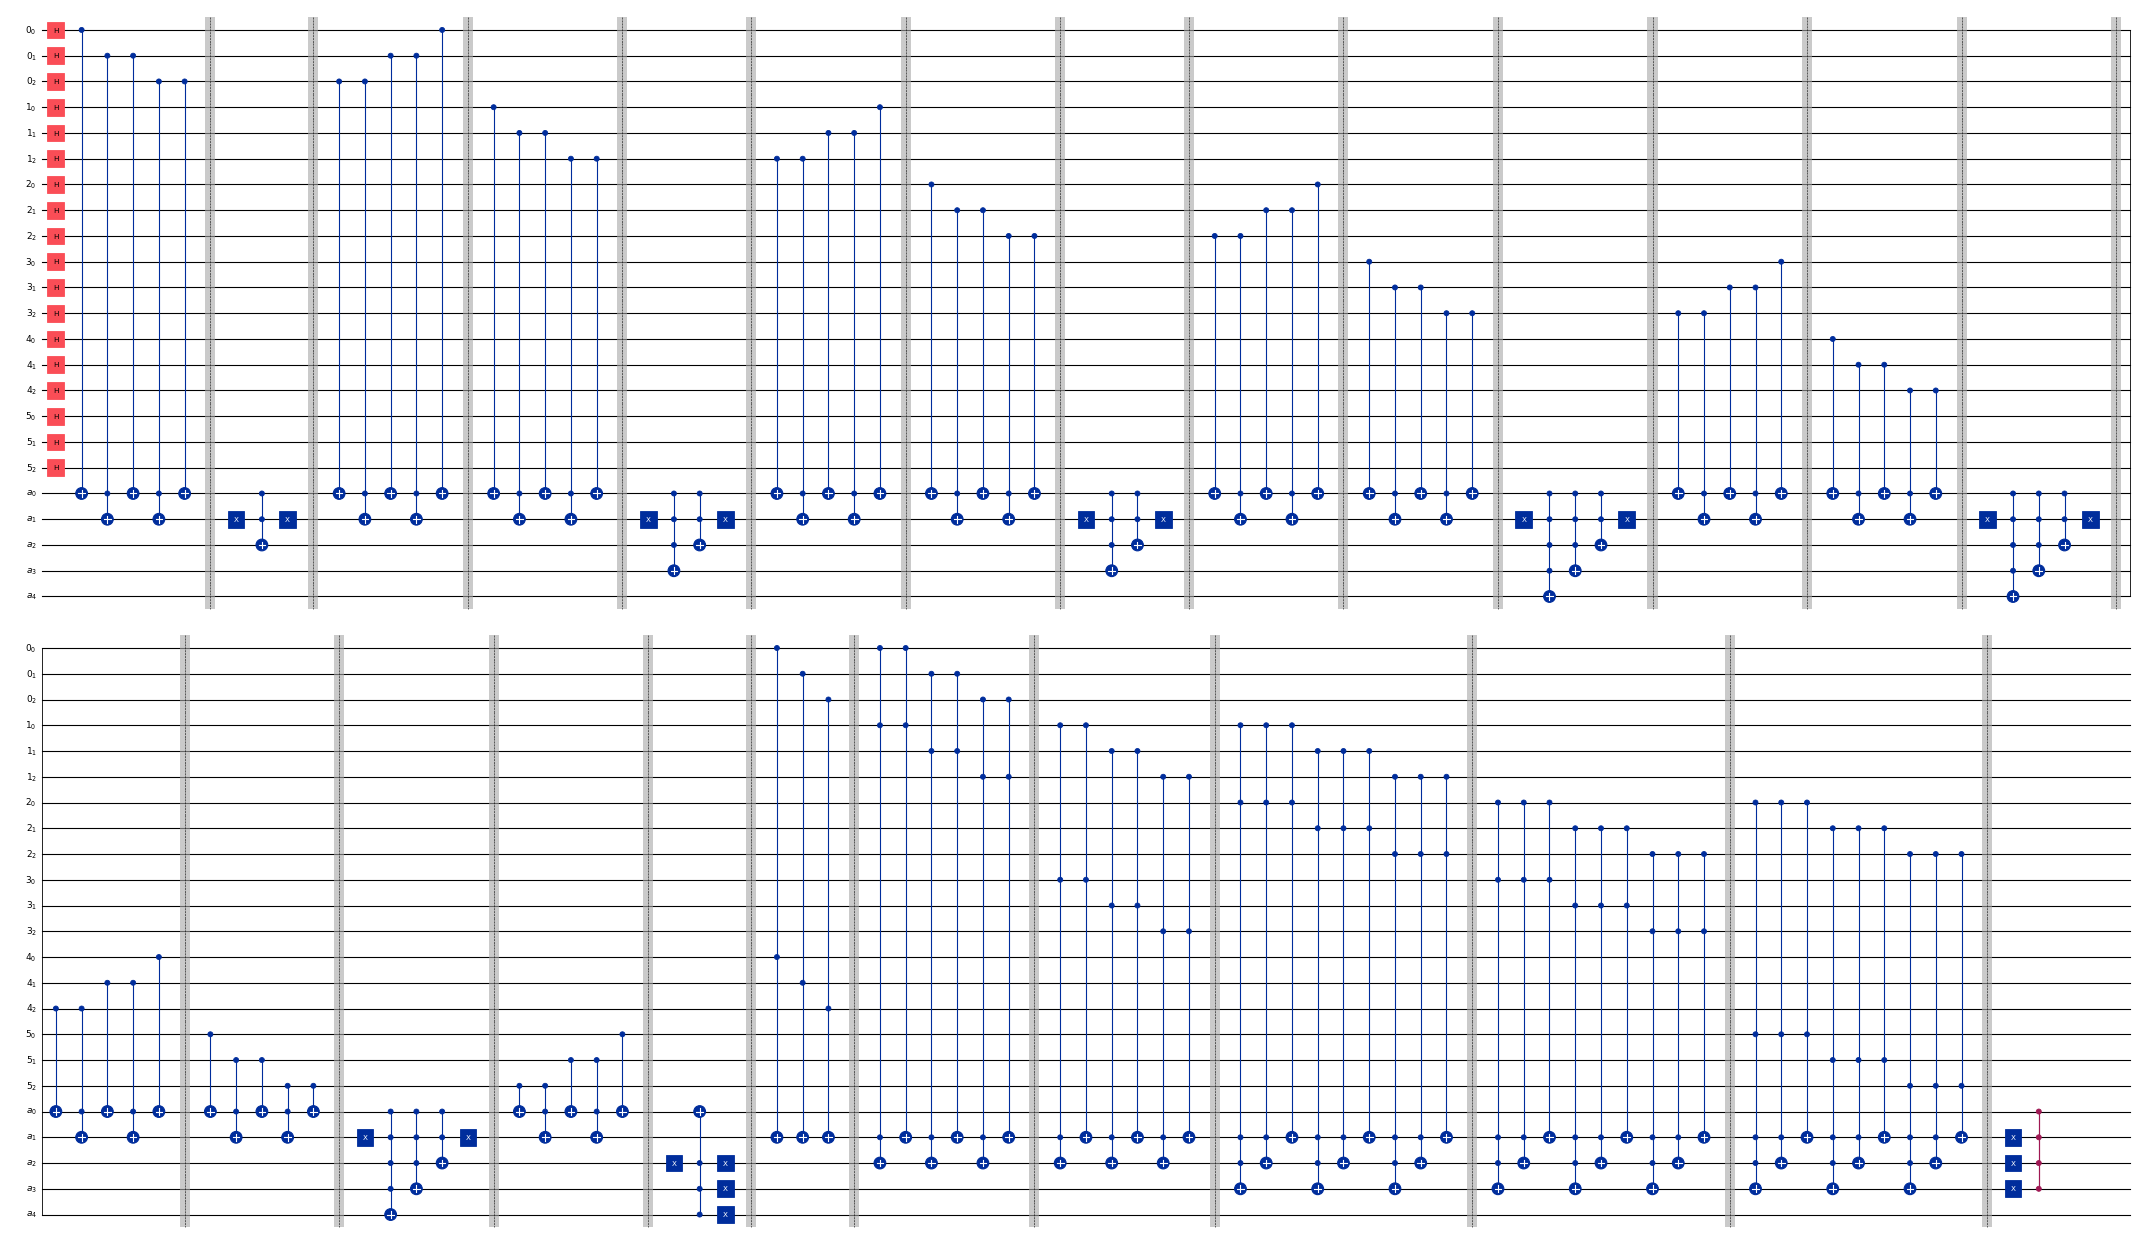

In [3]:
def f2_condicion1 (oracle, nodo0, nodo1, nodo2, nodo3, nodo4, nodo5, ancillas):
    tmp=oracle.copy_empty_like()
    cnt_c2 = qCounters.C_Counter(ancillas[:2], ancillas[2:5], tmp)
    for nodo in [nodo0, nodo1, nodo2, nodo3, nodo4, nodo5]:
        cnt_c1=qCounters.C_Ladder_Counter([nodo], ancillas[:2], tmp)
        while not cnt_c1.is_exhausted():
            tmp.compose(cnt_c1.next(), inplace=True)
        oracle.compose(tmp, inplace=True)
        oracle.barrier()
        oracle.x(ancillas[1])
        oracle.compose(cnt_c2.next(), inplace=True)
        oracle.x(ancillas[1])
        oracle.barrier()
        oracle.compose(tmp.reverse_ops(), inplace=True)
        oracle.barrier()
        tmp.clear()     

    oracle.x(ancillas[2])
    oracle.mcx(ancillas[2:5], ancillas[0])
    oracle.x(ancillas[2:5])
    oracle.barrier()  
    return oracle


def f2_condicion2(oracle, nodo0, nodo1, nodo2, nodo3, nodo4, nodo5, ancillas):
    aristas=[(nodo4, nodo0), (nodo0, nodo1), (nodo1, nodo3), (nodo1, nodo2), (nodo2, nodo3), (nodo2, nodo5)]
    list_cnts=[]
    for i in range(3):
        list_qbits=[[],[]]
        for a in aristas:
            list_qbits[0].append(a[0][i])
            list_qbits[1].append(a[1][i])
        list_cnts.append(qCounters.C_Ladder_Counter(list_qbits, ancillas[1:4], oracle))
    
    for a in aristas:
        for c in list_cnts:
            oracle.compose(c.next(), inplace=True)
        oracle.barrier()
    oracle.x(ancillas[1:4])
    return oracle

nodo20=qiskit.circuit.QuantumRegister(3, '0')
nodo21=qiskit.circuit.QuantumRegister(3, '1')
nodo22=qiskit.circuit.QuantumRegister(3, '2')
nodo23=qiskit.circuit.QuantumRegister(3, '3')
nodo24=qiskit.circuit.QuantumRegister(3, '4')
nodo25=qiskit.circuit.QuantumRegister(3, '5')
ancillas2=qiskit.circuit.AncillaRegister(5, 'a') 

circuito2 = qiskit.QuantumCircuit(nodo20, nodo21, nodo22, nodo23, nodo24, nodo25, ancillas2)

oracle2=circuito2.copy_empty_like()
oracle2_c2=circuito2.copy_empty_like()
f2_condicion1(oracle2, nodo20, nodo21, nodo22, nodo23, nodo24, nodo25, ancillas2)
f2_condicion2(oracle2_c2, nodo20, nodo21, nodo22, nodo23, nodo24, nodo25, ancillas2)
oracle2.compose(oracle2_c2,inplace=True)
oracle2_undo=oracle2.copy().reverse_ops()
quantum_f.phase_and(oracle2, [ancillas2[0], *ancillas2[1:4]])

for j in [nodo20, nodo21, nodo22, nodo23, nodo24, nodo25]:    circuito2.h(j)
circuito2.compose(oracle2, inplace=True)

circuito2.draw(output="mpl", scale=0.4, fold=81)


In [4]:
print(f"Profundidad circuito: {circuito2.depth()}") 
print(f"Número de puertas: {circuito2.size()}")

basis_gates = ['sx', 'x', 'rz', 'ecr'] # IBM Eagle Quantum Processor native gates

pass_manager = qiskit.transpiler.PassManager()
pass_manager.append(qiskit.transpiler.passes.UnrollCustomDefinitions(qiskit.circuit.equivalence_library.SessionEquivalenceLibrary, basis_gates))
pass_manager.append(qiskit.transpiler.passes.BasisTranslator(qiskit.circuit.equivalence_library.SessionEquivalenceLibrary, basis_gates))

transpiled_circuit2 = pass_manager.run(circuito2)
print(f"Número de puertas transpilado: {transpiled_circuit2.size()}")
print(f"Profundidad del circuito transpilado: {transpiled_circuit2.depth()}")
print(f"Número de puertas ECR: {transpiled_circuit2.count_ops().get('ecr', 0)}")
print(f"Número de puertas SX: {transpiled_circuit2.count_ops().get('sx', 0)}")

Profundidad circuito: 134
Número de puertas: 155
Número de puertas transpilado: 11218
Profundidad del circuito transpilado: 6619
Número de puertas ECR: 1070
Número de puertas SX: 1560


# Adición de 58 iteraciones Grover 
Puesto que el grafo de las JISBD tiene 48 soluciones, el numero de iteraciones Grover es 58

In [5]:
oracle2.compose(oracle2_undo, inplace=True)
circuito2.compose(oracle2_undo, inplace=True)
oracle2.barrier()
circuito2.barrier()
quantum_f.add_diffuser(oracle2, quantum_f.flatten_list([nodo20, nodo21, nodo22, nodo23, nodo24, nodo25]))
quantum_f.add_diffuser(circuito2, quantum_f.flatten_list([nodo20, nodo21, nodo22, nodo23, nodo24, nodo25]))


for i in range (58):
    circuito2.compose(oracle2, inplace=True)

#circuito2.draw(output="mpl", scale=0.4, fold=81)

In [6]:
print(f"Profundidad circuito: {circuito2.depth()}") 
print(f"Número de puertas: {circuito2.size()}")

transpiled_circuit58 = pass_manager.run(circuito2)
print(f"Número de puertas transpilado: {transpiled_circuit58.size()}")
print(f"Profundidad del circuito transpilado: {transpiled_circuit58.depth()}")
print(f"Número de puertas ECR: {transpiled_circuit58.count_ops().get('ecr', 0)}")
print(f"Número de puertas SX: {transpiled_circuit58.count_ops().get('sx', 0)}")

Profundidad circuito: 15931
Número de puertas: 20432
Número de puertas transpilado: 2568796
Profundidad del circuito transpilado: 1610560
Número de puertas ECR: 241900
Número de puertas SX: 395082


## Simulación del circuito completo e impresión de soluciones

In [7]:
st58its2 = qiskit.quantum_info.Statevector(circuito2)

In [8]:
[max_prob, combs] = quantum_f.max_prob_combinations(st58its2)
print("Max prob: ", max_prob*100, "%\nCombinations:")
for i in combs:
    print("|",i,"\u232A", sep='')
print(f"Num valores:", len(combs))

Max prob:  2.0800814103851755 %
Combinations:
|00000001001001010100010〉
|00000001001001100010100〉
|00000001001010100001010〉
|00000001001010100001100〉
|00000001001100010001010〉
|00000001001100010001100〉
|00000001010001010100001〉
|00000001010001100010001〉
|00000001010001100010100〉
|00000001010010100001100〉
|00000001010100010001100〉
|00000001100001010100001〉
|00000001100001010100010〉
|00000001100001100010001〉
|00000001100010100001010〉
|00000001100100010001010〉
|00000010001001100010100〉
|00000010001010001100010〉
|00000010001010100001010〉
|00000010001010100001100〉
|00000010001100001010100〉
|00000010010001100010001〉
|00000010010001100010100〉
|00000010010010001100001〉
|00000010010010100001100〉
|00000010010100001010001〉
|00000010010100001010100〉
|00000010100001100010001〉
|00000010100010001100001〉
|00000010100010001100010〉
|00000010100010100001010〉
|00000010100100001010001〉
|00000100001001010100010〉
|00000100001010001100010〉
|00000100001100001010100〉
|00000100001100010001010〉
|00000100001100010